LSM EXP 06_Aiffel
<br/>**6. 작사가 인공지능 만들기**

라이브러리
<br/>데이터 정보
<br/>데이터 탐색
<br/>데이터 시각화
<br/>데이터셋의 한계
* 문장 토큰화
* 데이터셋 노이즈
* 전처리 이후의 문장 길이 빈도 분포

데이터 전처리
* 특수문자, 공백 제거
* 문장 길이, 토큰 개수, 기호 제외

train, val 데이터 분리
<br/>학습 모델
<br/>학습 모델 (하이퍼 파라미터 조정)
<br/>평가 모델
<br/>가사 생성
<br/>결론
* 하이퍼 파라미터 튜닝
* 텍스트 데이터셋

참고문헌

#라이브러리

In [25]:
import glob
import tensorflow as tf
import numpy as np
import os
import re 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 

**glob**는 사용자가 제시한 조건에 맞는 파일명을 리스트 형식으로 반환한다.
<br/>단, 조건에 정규식을 사용할 수 없으며 엑셀 등에서도 사용할 수 있는 '*'와 '?'같은 와일드카드만을 지원한다.

**tensorflow**는 구글이 개발한 오픈소스 소프트웨어 딥러닝 및 머신러닝 라이브러리이다.
<br/>수학 계산식과 데이터의 흐름을 노드와 엣지를 사용한 방향성 그래프, 데이터 플로우 그래프로 나타낸다.

**numpy**는 array 단위로 벡터와 행렬을 계산한다. 이 라이브러리를 사용하기 위해서는 선형대수학 지식이 필요하다.

**os(Operating System)**는 운영체제에서 제공되는 여러 기능을 파이썬에서 수행한다. <br/>예를 들어, 파일 복사, 디렉터리 생성, 파일 목록을 구할 수 있다.

**re(regex)**는 특정 문자 또는 문자열이 존재하는지나 어느 위치에 있는지와 같은 기능을 제공하는 정규표현식 라이브러리이다.

**matplotlib**은 다양한 데이터와 학습 모델을 시각화한다.

 **sklearn.model_selection**는 훈련 데이터, 테스트 데이터를 분리한다.

#데이터 정보

[song_lyrics](https://aiffelstaticprd.blob.core.windows.net/media/documents/song_lyrics.zip)

49명의 가수의 영어 노래 가사를 수집한 텍스트 파일 모음 데이터셋이다.
<br/>가사 생성기(lyric Generator)를 만드는 데 사용된다.

#데이터 탐색

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
txt_file_path = '/content/drive/MyDrive/LMS/song_lyrics/*'

txt_list = glob.glob(txt_file_path)

raw_corpus = []

for txt_file in txt_list:
    with open(txt_file, "r") as f:
        raw = f.read().splitlines()
        raw_corpus.extend(raw)

print("데이터 크기:", len(raw_corpus))
print("Examples:\n", raw_corpus[:3])

데이터 크기: 187088
Examples:
 ['"Don\'t worry about a thing,', "'Cause every little thing gonna be all right.", 'Singin\': "Don\'t worry about a thing,']


이 데이터셋은 187088 문장으로 구성되어 있다.


**주의사항**
<br/>주소를 적을 때 txt_file_path = '.../*'의 끝에 별 *를 적어야 한다.
<br/>별을 빠뜨리면 IsADirectoryError: [Errno 21]라는 에러가 발생한다.

**glob.glob**는 사용자가 제시한 조건에 맞는 파일명을 리스트 형식으로 반환한다. <br/>특정 파일 경로 안에 있는 파일명을 불러왔다.


**splitlines**은 줄 단위로 문자열을 리스트로 변환한다.
<br/>그런데 split("\n')도 splitlines()와 동일한 결과값을 보여주기 때문에
<br/>문자열을 리스트로 변경할 때는 대부분 split()을 사용한다.


**extend**는 확장 함수로 다른 리스트를 연결한다.
<br/>여러개의 txt 파일을 모두 읽어서 raw_corpus 에 담는다.

**extend**와 **append**, **insert(a,b)**는 다른 형태의 추가 함수이니 때에 따라 다르게 쓴다.
<br/>**append**는 리스트의 끝에 x 값을 추가한다.
<br/>**insert(a,b)**는 리스트의 a 위치에 b 값을 추가한다.

#데이터 시각화

**matplotlib**을 이용해 문장 길이의 빈도 분포를 시각화한다.

최대 길이 : 1465
최소 길이 : 0
평균 길이 : 34.977070


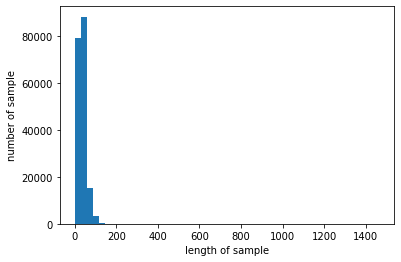

In [5]:
max_len = max(len(l) for l in raw_corpus)
print('최대 길이 : %d' % max_len)
print('최소 길이 : %d' % min(len(l) for l in raw_corpus))
print('평균 길이 : %f' % (sum(map(len, raw_corpus))/len(raw_corpus)))
plt.hist([len(s) for s in raw_corpus], bins=50)
plt.xlabel('length of sample')
plt.ylabel('number of sample')
plt.show()

1,000이 넘는 지나치게 긴 길이가 있는 문장이 존재한다.
<br/>왜 그럴까?

print를 이용해 직접 1,000이 넘는 문장을 출력해서 문제 원인을 확인한다.

In [6]:
for i in raw_corpus:
  if len(i) >= 1000:
    print(i)

WRITERS RUSSELL BROWN, IRWIN LEVINE I'm comin' home, I've done my time Now I've got to know what is and isn't mine If you received my letter telling you I'd soon be free Then you'll know just what to do if you still want me If you still want me Just tie a yellow ribbon 'round the old oak tree It's been way too long, do you still want me? If I don't see a ribbon 'round the old oak tree I'll just stay on the bus, forget about us, put the blame on me If I don't see a yellow ribbon 'round the old oak tree Bus driver, please look for me 'Cause I couldn't bear to see what I might see I'm really still in prison and my love, he holds the key A simple yellow ribbon's all I need to set me free I wrote and told him please... Just tie a yellow ribbon 'round the old oak tree It's been way too long, do you still want me? If I don't see a ribbon 'round the old oak tree I'll just stay on the bus, forget about us, put the blame on me If I don't see a ribbon 'round the old oak tree Tie a yellow ribbon '

데이터셋 자체의 문제이다.
<br/>웹크롤링 당시 줄바꿈되지 않은 채 여러 문장이 하나의 문장으로 이어져 txt 파일에 담긴 것이다.

#데이터셋의 한계

##문장 토큰화

문장 토큰화를 하는 함수 **nltk.tokenize**의 **sent_tokenize**가 있으나
<br/>마침표를 기준으로 문장을 나누기 때문에 길이가 1000이 넘는 문장을 구분할 수 없다.
<br/>이 문장 안에는 마침표가 존재하지 않는다.

> WRITERS RUSSELL BROWN, IRWIN LEVINE I'm comin' home, I've done my time Now I've got to know what is and isn't mine If you receive (생략)

##데이터셋 노이즈

In [49]:
entire_sentence_num = 0
for i in raw_corpus:
  entire_sentence_num += 1

print('전체 문장 개수 : %d' % entire_sentence_num)

fifteen_sentence_num = 0
for i in raw_corpus:
  if len(i) <= 14:
    fifteen_sentence_num += 1

print('토큰 15개 미만의 문장 개수 : %d' % fifteen_sentence_num)

num_difference = entire_sentence_num - fifteen_sentence_num
print('토큰 15개 기준 전처리 이후 제외되는 문장 개수 : %d' % num_difference)

전체 문장 개수 : 187088
토큰 15개 미만의 문장 개수 : 23268
토큰 15개 기준 전처리 이후 제외되는 문장 개수 : 163820


전처리를 통해 지나치게 긴 문장을 제외한 상황을 가정한다.

문장의 길이 15를 기준으로 전처리 이후 제외된 문장의 개수는 23268개이다.

23000개가 넘는 문장의 데이터를 잃지만 전처리를 통해 정제된 데이터를 얻을 수 있다.

In [78]:
delete_data_rate = round((23268 / 187088) * 100, 2)
print('전처리로 제외된 데이터 비율 : %.2f ' % delete_data_rate)

전처리로 제외된 데이터 비율 : 12.44 


전처리로 전체 데이터의 12.44%가 제외된다.

웹크롤링으로 가져온 데이터셋의 노이즈가 그만큼 많다는 것이다.

문장의 길이가 15를 넘어가는 문장을 제외하는 방법이 아닌 대안이 있어야하지 않을까?


웹에 업로드되어있는 데이터 자체의 문제로 인해 문장의 끝에 마침표가 없어서 
<br/>여러 문장이 합쳐져 '지나치게 긴 하나의 문장'이 된 노이즈를 
<br/>여러 문장으로 분할하여 '하나의 문장'이라는 정제된 데이터로 변환시켜주는 
<br/>전처리 기술이 개발되어야하지 않을까?

그 전처리 기술이 발달이 되면 12.44%와 같은 데이터양의 축소를 하지 않고
<br/>더 많은 웹크롤링 텍스트 데이터의 양을 확보할 수 있을 것이다.

##전처리 이후의 문장 길이 빈도 분포

최대 길이 : 14
최소 길이 : 0
평균 길이 : 5.154203


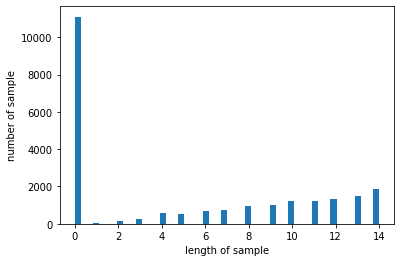

In [81]:
max_len = max([len(i) for i in raw_corpus if len(i) <= 14])
sum_len = sum([len(i) for i in raw_corpus if len(i) <= 14])
mean_len = sum_len / fifteen_sentence_num

print('최대 길이 : %d' % max_len)
print('최소 길이 : %d' % min(len(l) for l in raw_corpus))
print('평균 길이 : %f' % mean_len)
plt.hist([len(s) for s in raw_corpus if len(s) <= 14], bins=50)
plt.xlabel('length of sample')
plt.ylabel('number of sample')
plt.show()

In [82]:
j = 1
for i in raw_corpus:
  if len(i) == 108:
    while j < 2:
      print(i)
      j += 1

Who you are and where you stand in the struggle They go so very, so very, so very, so very, so very, so very


문장 길이 15 미만의 문장 중에서 가장 길이가 긴 문장의 사례이다.

문장 길이 15 미만으로 전처리했어도
<br/>여러 문장이 하나의 문장으로 합쳐진 사례가 등장한다.
<br/>데이터셋과 전처리 기술력의 한계이다.

#데이터 전처리

##특수문자, 공백 제거

In [91]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip() 
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence)
    sentence = sentence.strip()
    sentence = '<start> ' + sentence + ' <end>'
    return sentence


print(preprocess_sentence("This @_is ;;;sample        sentence."))

<start> this is sample sentence . <end>


**lower.strip**은 소문자로 바꾸고, 양쪽 공백을 지운다.


**sub**을 이용해 특수문자 양쪽에 공백을 넣는다.
<br/>여러개의 공백은 하나의 공백으로 바꾼다.
<br/>a-zA-Z?.!,¿가 아닌 모든 문자를 하나의 공백으로 바꾼다.

**strip**은 다시 양쪽 공백을 지운다.

문장 시작에는 start, 끝에는 end를 추가한다.

##문장 길이, 토큰 개수, 기호 제외

In [92]:
corpus = []

for sentence in raw_corpus:
    if len(sentence) == 0: continue
    if sentence[-1] == ":": continue
    
    preprocessed_sentence = preprocess_sentence(sentence)
    corpus.append(preprocessed_sentence)
        
corpus[:3]

['<start> don t worry about a thing , <end>',
 '<start> cause every little thing gonna be all right . <end>',
 '<start> singin don t worry about a thing , <end>']

corpus 리스트에 정제된 문장을 담는다.

문장의 길이가 0인 문장은 넘어간다.

마지막에 기호 :가 있는 문장은 리스트에 담지 않고 넘어간다.

In [93]:
def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=12000, 
        filters=' ',
        oov_token="<unk>"
    )
    
    tokenizer.fit_on_texts(corpus)
    tensor = tokenizer.texts_to_sequences(corpus)   
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post', maxlen=15)  
    
    print(tensor,tokenizer)
    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus)

[[   2   37   15 ...    0    0    0]
 [   2   67  133 ...    0    0    0]
 [   2 1551   37 ...    0    0    0]
 ...
 [   2   45  900 ...    0    0    0]
 [   2   45   66 ...    0    0    0]
 [   2    8   83 ...    0    0    0]] <keras_preprocessing.text.Tokenizer object at 0x7f375b898e10>


**tokenizer**는 내부 단어장의 크기를 12000로 갖는다.
<br/>단어장에 포함되지 못한 단어는 'unk'로 저장한다. 

준비한 tokenizer를 이용해 corpus를 Tensor로 변환한다.


**padding='post'**는 입력 데이터의 시퀀스 길이를 일정하게 맞춘다.
<br/>만약 시퀀스가 짧다면 문장 뒤에 패딩을 붙여 길이를 맞춰줍니다.

**maxlen=15**는 토큰의 개수가 15개 넘어가는 문장을 제외한다.
<br/>지나치게 긴 문장은 다른 데이터들이 과도한 Padding을 갖게 하므로 제거할 필요가 있다. 

In [94]:
print(tensor[:3, :10])

[[   2   37   15  717  113    9  181    4    3    0]
 [   2   67  133  117  181   96   27   24   84   20]
 [   2 1551   37   15  717  113    9  181    4    3]]


생성된 텐서 데이터를 3번째 행, 10번째 열까지만 출력한다.

In [98]:
for idx in tokenizer.index_word:
    print(idx, ":", tokenizer.index_word[idx])

    if idx >= 10: break

1 : <unk>
2 : <start>
3 : <end>
4 : ,
5 : i
6 : the
7 : you
8 : and
9 : a
10 : to


 tokenizer에 구축된 단어 사전의 인덱스를 통해 단어 사전이 어떻게 구축되었는지 확인한다.

In [99]:
src_input = tensor[:, :-1]  
tgt_input = tensor[:, 1:]    

print(src_input[0])
print(tgt_input[0])

[  2  37  15 717 113   9 181   4   3   0   0   0   0   0]
[ 37  15 717 113   9 181   4   3   0   0   0   0   0   0]


tensor에서 마지막 토큰을 잘라내서 소스 문장 **src_input**을 생성한다.


마지막 토큰은 end가 아니라 pad일 가능성이 높다.

tensor에서 start를 잘라내서 타겟 문장 **tgt_input**을 생성한다.

# train, val 데이터 분리

In [100]:
enc_train, enc_val, dec_train, dec_val = train_test_split(src_input, 
                                                    tgt_input,    
                                                    test_size=0.2,   
                                                    random_state=1)  

print('enc_train 개수: ', len(enc_train),', enc_val 개수: ', len(enc_val))

enc_train 개수:  140599 , enc_val 개수:  35150


**sklearnn** 모듈의 **train_test_split**를 이용해 데이터셋 분리를 한다.
<br/>소스 문장 **src_input**을 특징 데이터, 타겟 문장 **tgt_input**을 정답 데이터로 사용한다.
<br/>전체의 20%를 평가 데이터로 사용한다.
<br/>**random_state**는 데이터를 무작위로 정렬하여 분리한다.

In [101]:
print('Source Train: ', enc_train.shape)
print('Target Train: ', dec_train.shape)

Source Train:  (140599, 14)
Target Train:  (140599, 14)


In [102]:
BUFFER_SIZE = len(src_input)
BATCH_SIZE = 256
steps_per_epoch = len(src_input) // BATCH_SIZE
VOCAB_SIZE = tokenizer.num_words + 1   

dataset = tf.data.Dataset.from_tensor_slices((enc_train, dec_train))
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
dataset

<BatchDataset element_spec=(TensorSpec(shape=(256, 14), dtype=tf.int32, name=None), TensorSpec(shape=(256, 14), dtype=tf.int32, name=None))>

In [103]:
val_dataset = tf.data.Dataset.from_tensor_slices((enc_val, dec_val))
val_dataset = val_dataset.shuffle(BUFFER_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)
val_dataset

<BatchDataset element_spec=(TensorSpec(shape=(256, 14), dtype=tf.int32, name=None), TensorSpec(shape=(256, 14), dtype=tf.int32, name=None))>

**batch size**는 한 번에 네트워크에 넘겨주는 데이터의 수이다.
<br/>trade off로서 컴퓨터의 메모리 문제 때문에 분할해서 학습하는 것이다.

<br/>140599 ≥ 140544 = 256 * 549
<br/>train data num = batch size * step

<br/>35150 = 256 * 137 ≥ 35072
<br/>validation data num = batch size * step

<br/>주의할 점은 epoch와 batch size는 다른 개념이다.
<br/>epoch = batch size * step


**vocab size**는 tokenizer가 구축한 단어사전 내 7000개, 0 : pad를 포함하여 7001개를 포함한다.

#학습 모델

tf.keras.Model을 Subclassing하는 방식으로 만든다.
<br/>Embedding 레이어 1개, LSTM 레이어 2개, Dense 레이어 1개로 구성된다

In [151]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out

학습 모델 **model1**
<br/>하이퍼 파라미터를 조정한 학습 모델 **model2**
<br/>평가 모델 **model3**으로 설정한다.

In [152]:
embedding_size = 256
hidden_size = 1024
model1 = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

**Embedding 레이어**는 이 인덱스 값을 해당 인덱스 번째의 워드 벡터로 바꾼다.
<br/>워드 벡터는 의미 벡터 공간에서 단어의 추상적 표현(representation)으로 사용된다.

In [116]:
for src_sample, tgt_sample in dataset.take(1): break

model1(src_sample)

<tf.Tensor: shape=(256, 14, 12001), dtype=float32, numpy=
array([[[ 1.40947523e-04,  4.04085367e-05,  1.64556957e-04, ...,
          6.11222204e-05, -2.46991811e-04,  4.76812893e-05],
        [ 2.59152963e-04,  2.55710707e-04,  1.89954662e-04, ...,
          1.86881778e-04, -3.89832217e-04,  8.52760568e-05],
        [ 2.95058329e-04,  5.36240463e-04,  2.46459706e-04, ...,
         -4.28641688e-05, -6.16939215e-04, -1.75927722e-04],
        ...,
        [-1.45345042e-03, -2.98856728e-04,  1.50849461e-03, ...,
          7.21762364e-04, -1.26660115e-03, -1.49171310e-03],
        [-1.55146315e-03, -2.77278188e-04,  1.66823075e-03, ...,
          9.07679729e-04, -1.40510674e-03, -1.38349598e-03],
        [-1.61832012e-03, -2.38572218e-04,  1.83011149e-03, ...,
          1.09559565e-03, -1.55437400e-03, -1.24894211e-03]],

       [[ 1.40947523e-04,  4.04085367e-05,  1.64556957e-04, ...,
          6.11222204e-05, -2.46991811e-04,  4.76812893e-05],
        [ 2.32708277e-04,  4.01601574e-05,  3

데이터셋에서 데이터 한 배치만 불러온다.
<br/>한 배치만 불러온 데이터를 모델에 넣는다.

model의 input shape가 결정되면서 model.build()가 자동으로 호출된다.
<br/>

In [117]:
model1.summary()

Model: "text_generator_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     multiple                  3072256   
                                                                 
 lstm_14 (LSTM)              multiple                  5246976   
                                                                 
 lstm_15 (LSTM)              multiple                  8392704   
                                                                 
 dense_7 (Dense)             multiple                  12301025  
                                                                 
Total params: 29,012,961
Trainable params: 29,012,961
Non-trainable params: 0
_________________________________________________________________


In [118]:
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,
    reduction='none'
)

model1.compile(loss=loss, optimizer=optimizer)
model1.fit(dataset, epochs=10)

Epoch 1/10
549/549 [==============================] - 85s 151ms/step - loss: 3.6903
Epoch 2/10
549/549 [==============================] - 85s 155ms/step - loss: 3.1976
Epoch 3/10
549/549 [==============================] - 87s 158ms/step - loss: 3.0198
Epoch 4/10
549/549 [==============================] - 88s 160ms/step - loss: 2.8836
Epoch 5/10
549/549 [==============================] - 88s 160ms/step - loss: 2.7654
Epoch 6/10
549/549 [==============================] - 88s 160ms/step - loss: 2.6574
Epoch 7/10
549/549 [==============================] - 88s 160ms/step - loss: 2.5567
Epoch 8/10
549/549 [==============================] - 85s 155ms/step - loss: 2.4606
Epoch 9/10
549/549 [==============================] - 87s 158ms/step - loss: 2.3701
Epoch 10/10
549/549 [==============================] - 88s 160ms/step - loss: 2.2846


**model1**의 train loss는 2.2846이다.

#학습 모델 (하이퍼 파라미터 조정)

**model2**에서 하이퍼 파라미터를 다음과 같이 조정한다.
> embedding_size = 256 → 600
<br/>hidden_size = 1024 → 2048


In [147]:
embedding_size = 600
hidden_size = 2048
model2 = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

In [148]:
for src_sample, tgt_sample in dataset.take(1): break

model2(src_sample)

<tf.Tensor: shape=(256, 14, 12001), dtype=float32, numpy=
array([[[ 3.39108024e-04,  1.62792086e-04, -2.44630064e-04, ...,
         -6.35598408e-05, -1.29764143e-04,  4.72686865e-04],
        [ 8.98761442e-04,  6.57740107e-04, -3.33451433e-04, ...,
         -2.16741842e-04, -4.78792441e-04,  9.14298289e-04],
        [ 1.41155138e-03,  9.28761670e-04, -5.09645382e-04, ...,
         -4.61590738e-04, -7.08812498e-04,  1.24689669e-03],
        ...,
        [ 4.09965316e-04,  1.93638250e-03, -1.03193463e-03, ...,
         -4.12586407e-04, -8.39014887e-04,  8.14105952e-05],
        [ 4.07122425e-04,  1.88428944e-03, -8.22052360e-04, ...,
         -6.74766547e-04, -1.82157048e-04,  8.29519413e-05],
        [ 6.47721579e-04,  1.54634879e-03, -9.48799716e-04, ...,
         -7.36404036e-04,  3.55802244e-04,  2.61138863e-04]],

       [[ 3.39108024e-04,  1.62792086e-04, -2.44630064e-04, ...,
         -6.35598408e-05, -1.29764143e-04,  4.72686865e-04],
        [ 4.74448723e-04,  5.00936818e-04, -4

In [149]:
model2.summary()

Model: "text_generator_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    multiple                  7200600   
                                                                 
 lstm_30 (LSTM)              multiple                  21700608  
                                                                 
 lstm_31 (LSTM)              multiple                  33562624  
                                                                 
 dense_15 (Dense)            multiple                  24590049  
                                                                 
Total params: 87,053,881
Trainable params: 87,053,881
Non-trainable params: 0
_________________________________________________________________


In [150]:
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,
    reduction='none'
)

model2.compile(loss=loss, optimizer=optimizer)
model2.fit(dataset, epochs=10)

Epoch 1/10
549/549 [==============================] - 247s 447ms/step - loss: 3.4829
Epoch 2/10
549/549 [==============================] - 250s 455ms/step - loss: 2.8911
Epoch 3/10
549/549 [==============================] - 250s 455ms/step - loss: 2.5695
Epoch 4/10
549/549 [==============================] - 251s 457ms/step - loss: 2.2626
Epoch 5/10
549/549 [==============================] - 251s 456ms/step - loss: 1.9673
Epoch 6/10
549/549 [==============================] - 251s 457ms/step - loss: 1.6924
Epoch 7/10
549/549 [==============================] - 251s 456ms/step - loss: 1.4513
Epoch 8/10
549/549 [==============================] - 251s 456ms/step - loss: 1.2525
Epoch 9/10
549/549 [==============================] - 251s 456ms/step - loss: 1.1037
Epoch 10/10
549/549 [==============================] - 251s 456ms/step - loss: 1.0074


**model2**의 train loss는 1.0074이다.

#평가 모델

성능이 좋은 **model2**의 하이퍼 파라미터 값을 평가 모델 **model3**에 사용한다.
> embedding_size = 600
<br/>hidden_size = 2048




In [143]:
embedding_size = 600
hidden_size = 2048
model3 = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

In [144]:
for src_sample, tgt_sample in val_dataset.take(1): break

model3(src_sample)

<tf.Tensor: shape=(256, 14, 12001), dtype=float32, numpy=
array([[[-1.4913169e-04,  1.5645596e-04, -3.7385739e-04, ...,
          2.8522895e-04, -4.1372006e-04, -3.6882062e-04],
        [-2.4457051e-05,  4.7833633e-05, -3.4179442e-04, ...,
          5.9708761e-04, -4.0994101e-04, -4.7562204e-04],
        [ 1.5796947e-04,  1.2700519e-04, -3.1310885e-04, ...,
          6.8283046e-04, -6.1571982e-04, -4.6007056e-04],
        ...,
        [-3.7857862e-03,  3.4553516e-03,  1.9701649e-03, ...,
         -2.2496835e-03, -1.9925165e-03,  1.0253132e-03],
        [-4.2156843e-03,  3.6314451e-03,  2.3188677e-03, ...,
         -2.4916297e-03, -2.3248915e-03,  1.1366366e-03],
        [-4.5746313e-03,  3.7324128e-03,  2.6403668e-03, ...,
         -2.7112467e-03, -2.6112793e-03,  1.2271563e-03]],

       [[-1.4913169e-04,  1.5645596e-04, -3.7385739e-04, ...,
          2.8522895e-04, -4.1372006e-04, -3.6882062e-04],
        [ 4.8940892e-05,  4.5891435e-04, -5.1036256e-04, ...,
          1.1486997e-04, 

In [145]:
model3.summary()

Model: "text_generator_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    multiple                  7200600   
                                                                 
 lstm_28 (LSTM)              multiple                  21700608  
                                                                 
 lstm_29 (LSTM)              multiple                  33562624  
                                                                 
 dense_14 (Dense)            multiple                  24590049  
                                                                 
Total params: 87,053,881
Trainable params: 87,053,881
Non-trainable params: 0
_________________________________________________________________


In [146]:
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,
    reduction='none'
)

model3.compile(loss=loss, optimizer=optimizer)
model3.fit(val_dataset, epochs=10)

Epoch 1/10
137/137 [==============================] - 62s 436ms/step - loss: 4.1889
Epoch 2/10
137/137 [==============================] - 61s 447ms/step - loss: 3.4904
Epoch 3/10
137/137 [==============================] - 62s 452ms/step - loss: 3.2521
Epoch 4/10
137/137 [==============================] - 62s 456ms/step - loss: 3.0824
Epoch 5/10
137/137 [==============================] - 63s 458ms/step - loss: 2.9260
Epoch 6/10
137/137 [==============================] - 63s 457ms/step - loss: 2.7697
Epoch 7/10
137/137 [==============================] - 63s 456ms/step - loss: 2.6076
Epoch 8/10
137/137 [==============================] - 63s 456ms/step - loss: 2.4342
Epoch 9/10
137/137 [==============================] - 63s 457ms/step - loss: 2.2557
Epoch 10/10
137/137 [==============================] - 63s 457ms/step - loss: 2.0739


**model3**의 valadation loss는 2.0739이다.

#가사 생성

In [153]:
def generate_text(model, tokenizer, init_sentence="<start>", max_len=20):
   
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    while True:
        # 1
        predict = model(test_tensor) 
        # 2
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1] 
        # 3 
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        # 4
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated

**tf.convert_to_tensor**는 테스트를 위해서 입력받은 init_sentence도 텐서로 변환한다.

**while Loop**에서 단어를 하나씩 예측해 문장을 만든다.
<br/>1) 입력받은 문장의 텐서를 입력한다.
<br/>2) 예측된 값 중 가장 높은 확률인 word index를 뽑아낸다.
<br/>3) 2에서 예측된 word index를 문장 뒤에 붙인다.
<br/>4) 모델이 <end>를 예측했거나, max_len에 도달했다면 문장 생성을 마친다.

**tokenizer**를 이용해 word index를 단어로 하나씩 변환합니다 

성능이 좋은 학습 모델 **model2**를 사용해 가사를 생성한다.

In [170]:
generate_text(model2, tokenizer, init_sentence="<start> i love")

'<start> i love the way you lie <end> '

In [162]:
generate_text(model2, tokenizer, init_sentence="<start> good")

'<start> good day sunshine , <end> '

In [164]:
generate_text(model2, tokenizer, init_sentence="<start> morning")

'<start> morning glow is almost here <end> '

In [165]:
generate_text(model2, tokenizer, init_sentence="<start> I gonna")

'<start> i gonna make it work . i didn t brush my hair <end> '

In [169]:
generate_text(model2, tokenizer, init_sentence="<start> where")

'<start> where the eyelids go verse <end> '

#결론

##하이퍼 파라미터 튜닝

**model2**에서 하이퍼 파라미터를 다음과 같이 조정한다.
> embedding_size = 256 → 600
<br/>hidden_size = 1024 → 2048

성능이 좋은 **model2**의 하이퍼 파라미터 값을 평가 모델 **model3**에 사용한다.
> embedding_size = 600
<br/>hidden_size = 2048

**model1**의 train loss는 2.2846이다.
<br/>**model2**의 train loss는 1.0074이다.
<br/>**model3**의 valadation loss는 2.0739이다.

하이퍼 파라미터 조정으로 train loss는 감소했지만
<br/>train loss와 valadation loss의 차이는 1.0665이다.

embedding_size가 커지고 hidden_size가 깊어져서
과적합이 발생한 것인가?
<br/>하이퍼 파라미터 값이 크다고 성능이 좋아질거라는 보장은 없다.

또한 튜닝에 있어서 무슨 하이퍼 파라미터를 선택해야 하는가?
<br/>embedding_size, hidden_size 튜닝은 무슨 시사점을 남기는가?

하이퍼 파라미터 튜닝 결과에 대한 분석 방법을 알고자 튜닝 관련 논문을 찾아보았다.

[RNN모델에서 하이퍼 파라미터 변화에 따른 정확도와 손실 성능, 분석융합정보논문지 v.11 no.7, 2021, pp.31 - 38, 김준용, 박구락](https://www.koreascience.or.kr/article/JAKO202123157143805.pdf)


위의 논문에서는 LSTM의 unit, batch_size, embedding_size를 조정한다.


unit, batch_size, embedding_size 튜닝은 무슨 시사점을 남기는가?
* embedding_size가 가장 영향력이 큰 하이퍼 파라미터였다.
* Unit의 개수가 적을수록 batch_size가 클 수록 성능이 높아진다.
* Embedding size이 커지면 성능이 높아졌다가 낮아진다.

이렇게 하이퍼 파라미터 튜닝의 결과에 대해 분석할 수 있었던 이유는
<br/>연구자가 하이퍼 파라미터 변화에 따른 Loss와 Accuracy의 추이를 표로 정리했기 때문이다.

모델의 변화에 따른 학습 결과를 문서로 정리할 수 있는 알고리즘을 짜는 방법을 알고 싶다.

## 텍스트 데이터셋

* 데이터 노이즈에 대한 사전지식을 갖추고 웹크롤링과 데이터 전처리를 진행해야한다.
* 문장 부호가 작성되지 않았거나 띄어쓰기가 되지 않은 상황에서 토큰의 단위에 따라 어떻게 분리하는가?



#참고문헌

[Python glob.glob() 사용법](https://m.blog.naver.com/PostView.naver?isHttpsRedirect=true&blogId=siniphia&logNo=221397012627)

[text_generation_shakespeare_rnn.ipynb](https://colab.research.google.com/github/trekhleb/machine-learning-experiments/blob/master/experiments/text_generation_shakespeare_rnn/text_generation_shakespeare_rnn.ipynb#scrollTo=bui0MyTjv1Mp)

[OS 모듈](https://wikidocs.net/3141)

[Python re 모듈 사용법](https://brownbears.tistory.com/506)

[Python glob.glob() 사용법](https://m.blog.naver.com/PostView.naver?isHttpsRedirect=true&blogId=siniphia&logNo=221397012627)


[Python 리스트(List)와 리스트 메소드(append, insert, remove, pop, extend)](https://velog.io/@falling_star3/%ED%8C%8C%EC%9D%B4%EC%8D%AC%EC%9D%98-%EB%A6%AC%EC%8A%A4%ED%8A%B8List%EC%99%80-%EA%B4%80%EB%A0%A8-%ED%95%A8%EC%88%98%EB%93%A4append-insert-remove-pop-extend)


[파이썬 문자열을 리스트로 만들기 – split, splitlines](https://m.blog.naver.com/PostView.naver?isHttpsRedirect=true&blogId=debolm74&logNo=221953881991)

[PyTorch로 시작하는 딥 러닝 입문  / 01. 자연어 처리 전처리 이해하기](https://wikidocs.net/64517)

[4. 텍스트 전처리(정규화)](https://blockchainstudy.tistory.com/58)

[PYTHON / NLTK 텍스트 파일 문장 단위로 분해하기 (SENTENCE TOKENIZE)](https://cryptosalamander.tistory.com/140)

[Python에서 문자열의 단어 계산](https://www.delftstack.com/ko/howto/python/python-count-words-in-string/)

[15.Batch size & Batch Norm](https://nittaku.tistory.com/293)


[RNN모델에서 하이퍼 파라미터 변화에 따른 정확도와 손실 성능, 분석융합정보논문지 v.11 no.7, 2021, pp.31 - 38, 김준용, 박구락](https://www.koreascience.or.kr/article/JAKO202123157143805.pdf)
